In [57]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, ch_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist
import topology

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [58]:
seed = 4
np.random.seed(seed)

device_number = 1000 + 1
avg = 50
c_capacity = 50
max_resources = device_number * avg - c_capacity

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
centers = 40

H, bins = get_lognorm_hist()
coords_df = topology.coords_sim(1000, centers, X_dim_range, Y_dim_range, seed)
coord_dict = {"sim(1000)": coords_df}

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=10, kmax=30, kseed=10)

Creating df for sim(1000)
Optimal k is 21
Done


In [59]:
t_label = "sim(1000)"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,71.925332,25.565323,0.000000,coordinator,9223372036854775807,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,24.775013,11.958341,49.074459,worker,9223372036854775807,1,50,48,49,44,...,54,40,34,34,73,27,77,1,1,2
2,5.770977,8.497964,68.320520,worker,9223372036854775807,1,50,53,48,42,...,59,53,58,42,34,11,27,11,1,2
3,30.952786,-3.329505,50.136420,worker,9223372036854775807,1,50,49,54,44,...,43,37,58,28,38,27,8,1,1,2
4,18.231240,4.925715,57.524334,worker,9223372036854775807,27,50,49,55,44,...,58,51,35,33,17,14,0,11,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,88.052679,11.635696,21.310228,worker,9223372036854775807,1,50,48,52,52,...,62,75,47,59,17,38,39,6,1,2
997,34.643330,-22.089226,60.505403,worker,9223372036854775807,1,50,52,50,47,...,48,40,48,28,27,30,119,16,1,2
998,20.830278,17.439655,51.737134,worker,9223372036854775807,1,50,50,47,57,...,57,66,38,26,99,94,154,11,1,2
999,36.871673,9.978153,38.362988,worker,9223372036854775807,12,50,50,49,53,...,54,34,38,44,79,59,4,19,1,2


In [60]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 5971 Available: 50050


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

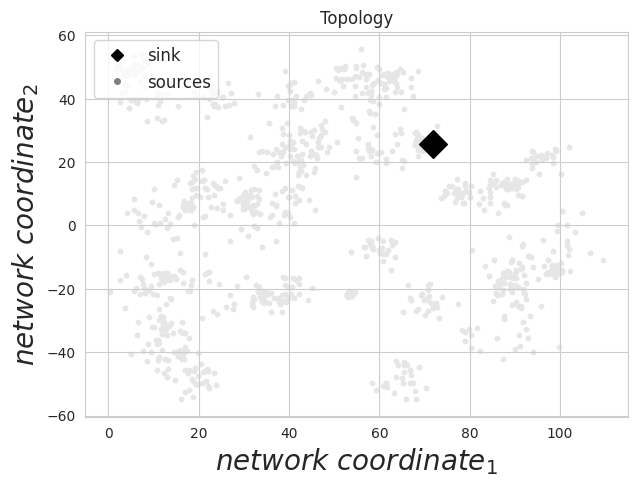

In [61]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, scale_fac=0.1)

#ax1.set_xlim(X_dim_def)
#ax2.set_xlim(X_dim_def)

#ax1.set_ylim(Y_dim_def)
#ax2.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")

plt.show()

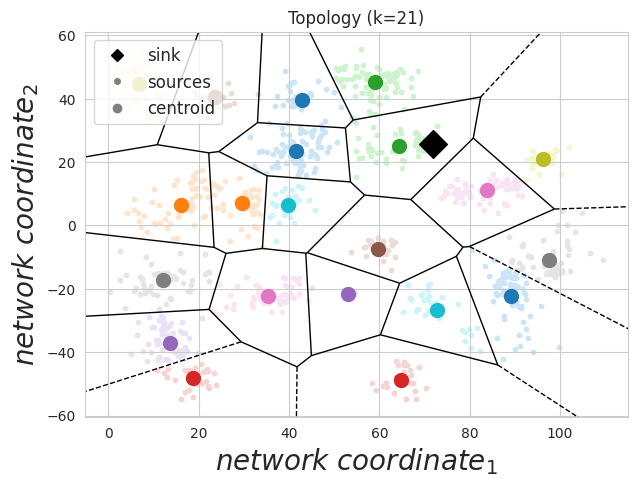

In [62]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.1,
                         plot_voronoi=True, plot_centroid=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_grouped.svg", bbox_inches="tight")

plt.show()

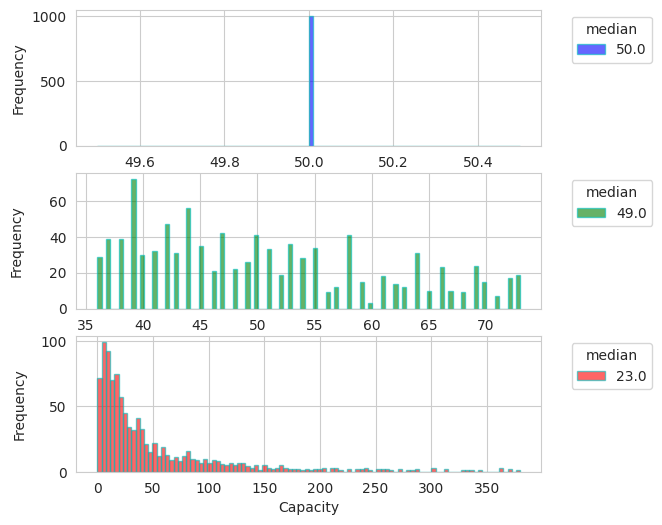

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

i = 100
prim_df["capacity_" + str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_xlabel("Capacity")

# Set y-axis label with padding
ax2.set_ylabel("Frequency", labelpad=18)
ax3.set_ylabel("Frequency", labelpad=10)
plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")

plt.show()

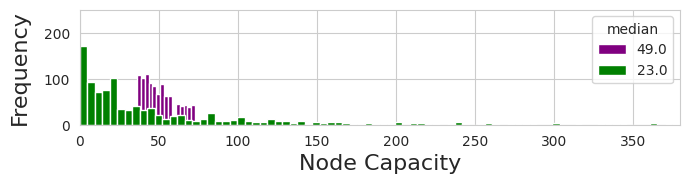

In [64]:
fig, (merged_ax) = plt.subplots(1, 1, figsize=(7, 2))

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=15, alpha=1, color='purple',
                                        label=prim_df["capacity_" + str(i)].median())

#i = 10
#prim_df["capacity_"+str(i)].plot.hist(ax=merged_ax, bins=40, alpha=1, color='orange', label=prim_df["capacity_"+str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=80, alpha=1, color='green',
                                        label=prim_df["capacity_" + str(i)].median())

merged_ax.legend(title='median', loc='upper right')
merged_ax.set_xlabel("Node Capacity")

# Set y-axis label with padding
merged_ax.set_ylabel("Frequency", labelpad=10)

# Set the same x-axis limits for both histograms
xlim = (prim_df["capacity_1"].min(), prim_df["capacity_1"].max())
merged_ax.set_xlim(xlim)
merged_ax.set_ylim([0, 250])

merged_ax.yaxis.label.set_size(16)
merged_ax.xaxis.label.set_size(16)
#merged_ax.tick_params(axis='x', labelsize=20)

# Adjust figure layout for better display
fig.tight_layout()

plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")
plt.show()

Medians from  50  to  25


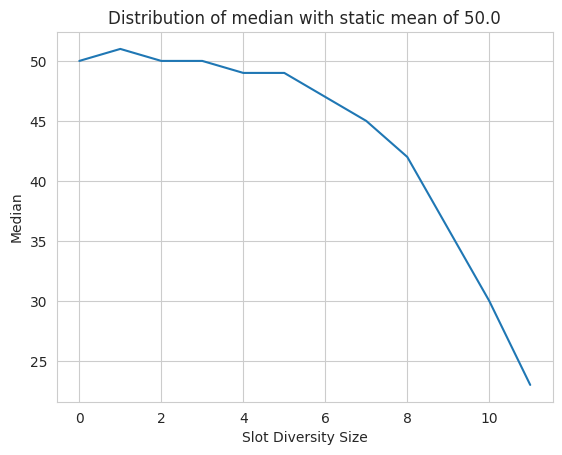

In [65]:
medians = []
mean = np.floor(prim_df["capacity_" + str(1)].mean())

for col in slot_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = "50"
last_med_label = "25"
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("Slot Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator


In [66]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
print(df_stats)
eval_matrix["dt"] = df_stats.copy()

      latency_distribution  received_packets
0                 0.000000            1000.0
1                49.074459               0.0
2                68.320520               0.0
3                50.136420               0.0
4                57.524334               0.0
...                    ...               ...
996              21.310228               0.0
997              60.505403               0.0
998              51.737134               0.0
999              38.362988               0.0
1000             27.218134               0.0

[1001 rows x 2 columns]


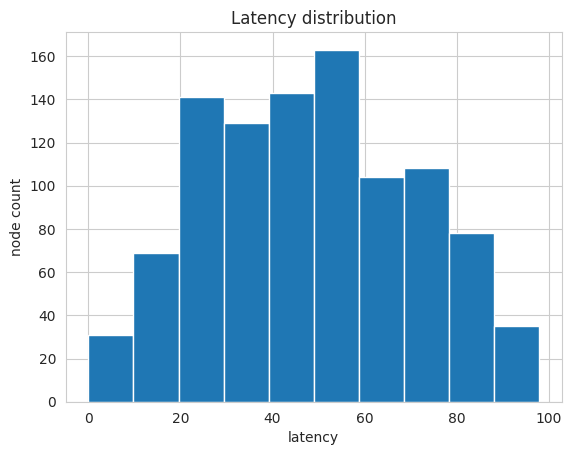

In [67]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
plt.show()

In [68]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"]
print("Distribution of workload: ", 1, "/", device_number, "=", round(len(df_packets) / device_number * 100, 5), "%")

Distribution of workload:  1 / 1001 = 0.0999 %


### Experiment 1: LEACH Protocol

In [69]:
seed = 10
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(0.1 * device_number)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  100
[586, 34, 440, 495, 592, 16, 212, 474, 833, 504, 844, 285, 670, 831, 165, 36, 534, 502, 336, 78, 256, 976, 979, 764, 370, 46, 431, 881, 143, 618, 364, 391, 432, 291, 847, 692, 269, 468, 179, 703, 311, 678, 372, 137, 963, 787, 973, 246, 451, 629, 385, 975, 597, 5, 242, 138, 200, 932, 960, 550, 375, 791, 920, 953, 322, 683, 563, 462, 447, 482, 67, 669, 599, 333, 865, 514, 161, 863, 230, 423, 245, 38, 33, 509, 309, 838, 622, 674, 74, 547, 876, 83, 154, 394, 581, 384, 616, 908, 116, 795]


In [70]:
df_stats

,latency_distribution,received_packets
0,0.000000,100.0
1,49.865080,0.0
2,72.428582,0.0
3,51.234684,0.0
4,57.746384,0.0
...,...,...
996,21.676708,0.0
997,61.106891,0.0
998,61.849045,0.0
999,39.150472,0.0


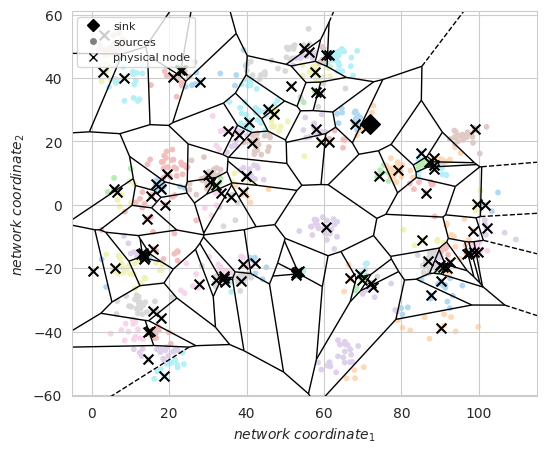

In [71]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, ch_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/sim_1000/leach.svg")
plt.show()

count    1001.000000
mean       50.839459
std        23.055000
min         0.000000
25%        32.266605
50%        50.002959
75%        69.308042
max       103.781689
Name: latency_distribution, dtype: float64


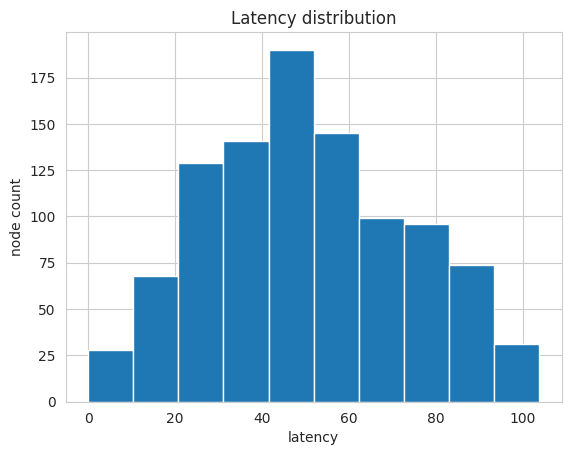

In [72]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

In [73]:
eval_matrix["leach"] = df_stats.copy()

### Experiment 2a: NEMO Aggregation with Density-based Grouping

### Identify parameters

In [74]:
# fixed params
max_levels = 50
slot_col = "capacity_1"
weight_col = "weight"

# dynamic params
num_points = 9
start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(start, end, num_points)
hyperparam_values_2 = np.linspace(start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.zeros_like(X)
mean_lat_values = np.zeros_like(X)

for i in range(num_points):
    for j in range(num_points):
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j],
                                                                  step_size=Y[i, j], max_levels=max_levels,
                                                                  with_eval=True)
        sv = eval_dict[slot_col]["latency_distribution"]
        perc_lat = sv.quantile(0.9).round(2)
        mean_lat = sv.mean().round(2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

Starting nemo for: c=capacity_1, w=weight, l=50, step_size=0.1, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  116
--------Balancing load for 2 clusters to 0
Clusters processed: 0
Level 2 CH number:  11
--------Balancing load for 1 clusters to 0
Clusters processed: 0
Level 3 CH number:  5
Evaluating for capacity_1
104.85 81.42
Starting nemo for: c=capacity_1, w=weight, l=50, step_size=0.1, merge_factor=0.2
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  116
--------Balancing load for 4 clusters to 0
Clusters processed: 0
Level 2 CH number:  10
Evaluating for capacity_1
65.64 46.43
Starting nemo for: c=capacity_1, w=weight, l=50, step_size=0.1, merge_factor=0.30000000000000004
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters p

merge factor and step size for minimum latency (90P): (X=0.30000000000000004, Y=0.1) 63.31
merge factor and step size for minimum latency (mean): (X=0.30000000000000004, Y=0.1) 43.27


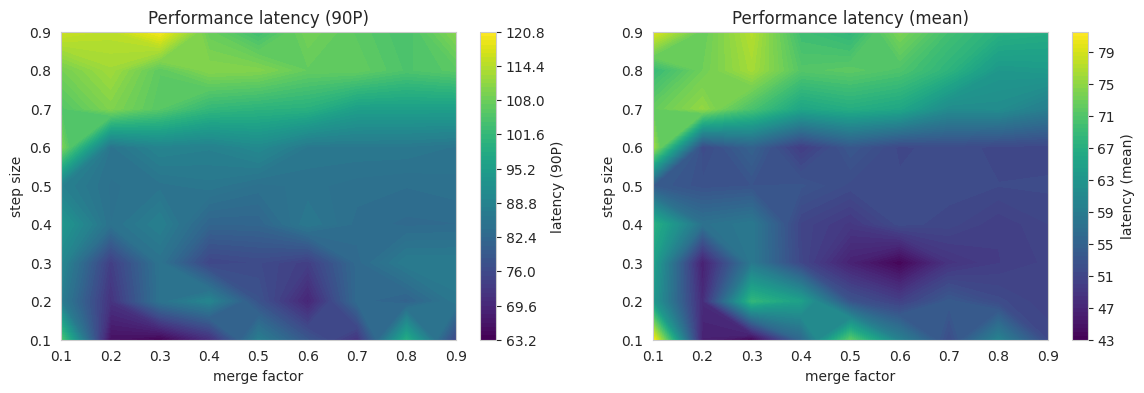

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"

    # Find the indices of the minimum Z value
    min_index = np.unravel_index(np.argmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])

    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)

    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')

plt.show()

In [76]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.3},
    "weight_2": {"merge_factor": 0.9, "step_size": 0.2},
    "weight": {"merge_factor": 0.4, "step_size": 0.4},
    
    "capacity_100": { 
    "weight_1": {"merge_factor": 0.1, "step_size": 0.3},
    "weight_2": {"merge_factor": 0.9, "step_size": 0.2},
    "weight": {"merge_factor": 0.4, "step_size": 0.4}
    },
    "capacity_1": {
        "weight_1": {"merge_factor": 0.1, "step_size": 0.3},
        "weight_2": {"merge_factor": 0.9, "step_size": 0.2},
        "weight": {"merge_factor": 0.8, "step_size": 0.2}
    }
}

In [77]:
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,71.925332,25.565323,0.000000,coordinator,9223372036854775807,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,24.775013,11.958341,49.074459,worker,9223372036854775807,1,50,48,49,44,...,54,40,34,34,73,27,77,1,1,2
2,5.770977,8.497964,68.320520,worker,9223372036854775807,1,50,53,48,42,...,59,53,58,42,34,11,27,11,1,2
3,30.952786,-3.329505,50.136420,worker,9223372036854775807,1,50,49,54,44,...,43,37,58,28,38,27,8,1,1,2
4,18.231240,4.925715,57.524334,worker,9223372036854775807,27,50,49,55,44,...,58,51,35,33,17,14,0,11,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,88.052679,11.635696,21.310228,worker,9223372036854775807,1,50,48,52,52,...,62,75,47,59,17,38,39,6,1,2
997,34.643330,-22.089226,60.505403,worker,9223372036854775807,1,50,52,50,47,...,48,40,48,28,27,30,119,16,1,2
998,20.830278,17.439655,51.737134,worker,9223372036854775807,1,50,50,47,57,...,57,66,38,26,99,94,154,11,1,2
999,36.871673,9.978153,38.362988,worker,9223372036854775807,12,50,50,49,53,...,54,34,38,44,79,59,4,19,1,2


In [78]:
# for the eval for weights regarding latency
weight_cols = ["weight_1", "weight_2", "weight"]

for weight_col in weight_cols:
    eval_name = "nemo_dc" + "_" + weight_col
    eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, ["capacity_100", "capacity_1"],
                                                                           weight_col,
                                                                           merge_factor=param_dict[weight_col][
                                                                               "merge_factor"],
                                                                           step_size=param_dict[weight_col][
                                                                               "step_size"], with_eval=True)

Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  33
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_1, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  46
Evaluating for capacity_1
Starting nemo for: c=capacity_100, w=weight_2, l=20, step_size=0.2, merge_factor=0.9
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  55
--------Balancing load for 18 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 2 CH number:  21
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_2, l=20, step_size=0.2, merge_f

In [79]:
eval_matrix["nemo_dc_weight"]["capacity_100"]

,latency_distribution,received_packets
0,0.000000,9.0
780,6.805741,49.0
620,7.063575,48.0
886,8.082159,50.0
964,13.842273,22.0
...,...,...
373,50.651489,0.0
374,47.997970,0.0
375,58.872589,0.0
376,29.893998,0.0


In [80]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight_1"
df_dict_1, opt_dict_1, limits_dict_1 = evaluate_nemo(prim_df, [slot_col], weight_col, max_levels=1,
                                                     merge_factor=param_dict[weight_col]["merge_factor"],
                                                     step_size=param_dict[weight_col]["step_size"], with_eval=False)
eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, slot_columns, weight_col,
                                                                       merge_factor=param_dict[weight_col][
                                                                           "merge_factor"],
                                                                       step_size=param_dict[weight_col]["step_size"],
                                                                       with_eval=True)

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.3, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  33
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  33
Evaluating for capacity_100
Starting nemo for: c=capacity_90, w=weight_1, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  32
Evaluating for capacity_90
Starting nemo for: c=capacity_80, w=weight_1, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters proce

In [81]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,71.925332,25.565323,coordinator,-1,<NA>,<NA>,<NA>,50,17,1,<NA>,33
1,1,24.775013,11.958341,worker,1,1,0,1,50,50,0,757,0
2,2,5.770977,8.497964,worker,11,1,0,1,50,50,0,707,0
3,3,30.952786,-3.329505,worker,1,1,-1,1,50,2,1,757,48
4,3,30.952786,-3.329505,worker,1,1,-1,1,50,2,1,0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,996,88.052679,11.635696,worker,6,1,0,1,50,50,0,652,0
1030,997,34.643330,-22.089226,worker,16,1,0,1,50,50,0,603,0
1031,998,20.830278,17.439655,worker,11,1,0,1,50,50,0,379,0
1032,999,36.871673,9.978153,worker,19,1,0,1,50,50,0,959,0


In [82]:
df[df["parent"] == df["oindex"]]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
50,49,62.489922,-4.518407,worker,15,1,-1,1,50,25,1,49,25
111,107,50.642920,26.319947,worker,20,1,-1,1,50,28,1,107,22
123,118,63.510658,42.133360,worker,2,1,-1,1,50,28,1,118,22
221,211,92.587302,20.742839,worker,18,1,-1,1,50,24,1,211,26
307,294,80.282731,12.603223,worker,6,1,-1,1,50,24,1,294,26
401,385,67.925761,25.464747,worker,12,1,-1,1,50,2,1,385,48
458,441,71.162389,-18.438244,worker,9,1,-1,1,50,17,1,441,33
612,590,80.521410,-7.869914,worker,0,1,-1,1,50,38,1,590,12
938,908,51.584279,37.468168,worker,10,1,-1,1,50,18,1,908,32


In [83]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
4,3,30.952786,-3.329505,worker,1,1,-1,1,50,2,1,0,48
51,49,62.489922,-4.518407,worker,15,1,-1,1,50,25,1,0,25
74,71,30.381888,-16.397386,worker,16,1,-1,1,50,29,1,0,21
104,100,67.849116,25.862733,worker,12,1,-1,1,50,48,1,0,2
112,107,50.642920,26.319947,worker,20,1,-1,1,50,28,1,0,22
124,118,63.510658,42.133360,worker,2,1,-1,1,50,28,1,0,22
138,131,32.698057,-18.833765,worker,16,1,-1,1,50,2,1,0,48
158,150,88.649333,-3.629577,worker,17,1,-1,1,50,2,1,0,48
186,177,37.121872,-4.847426,worker,19,1,-1,1,50,39,1,0,11
189,179,85.380736,-10.992089,worker,0,1,-1,1,50,2,1,0,48


In [84]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [85]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [86]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,17,0,33,17
1,3,50,2,3,48,2
2,3,50,2,3,48,2
3,49,50,25,49,25,25
4,49,50,25,49,25,25
...,...,...,...,...,...,...
62,908,50,18,908,32,18
63,959,50,24,959,26,24
64,959,50,24,959,26,24
65,986,50,30,986,20,30


In [87]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

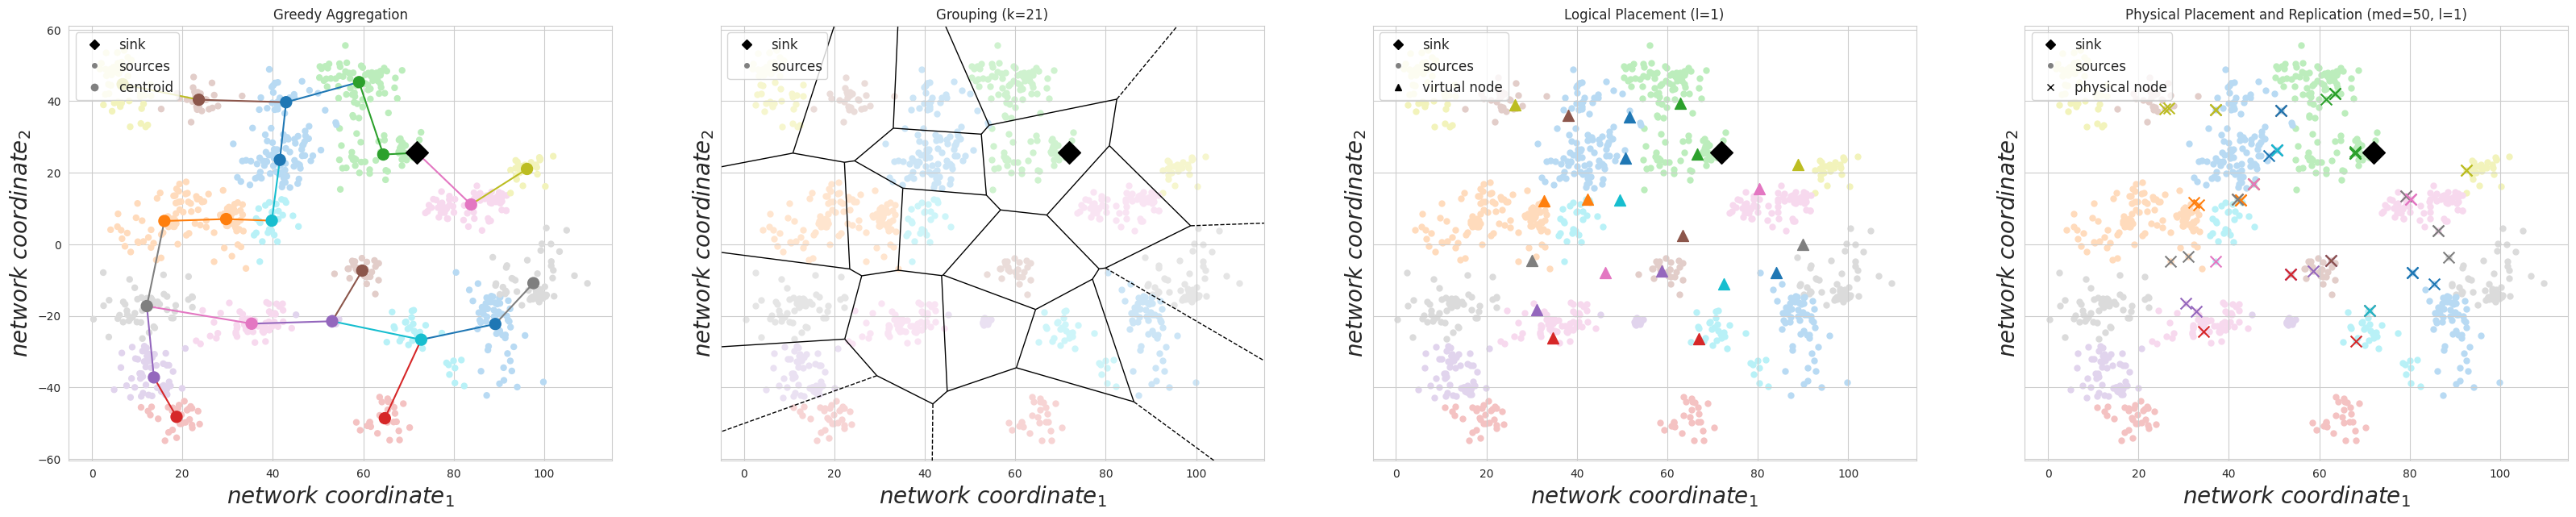

In [88]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")

lval = 0.28
leg_size = 12
symbol_size = 100
scale_fac = 0.25
axis_label_size = 20

labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=2 * symbol_size, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=symbol_size, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=scale_fac * symbol_size,
            color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=leg_size)

ax1.set_xlabel('$network$ $coordinate_1$', fontsize=axis_label_size)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=axis_label_size)
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

# TODO: unify the two below plots into a single one
#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False,
                  leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)
# plot physical nodes
util.plot(ax4, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False,
          leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

plt.xlim(X_dim)
plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + first_med_label + ", l=1)")

plt.savefig("plots/sim_1000/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for: c=capacity_10, w=weight_2, l=1, step_size=0.2, merge_factor=0.9
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  57
Starting nemo for: c=capacity_10, w=weight_2, l=2, step_size=0.2, merge_factor=0.9
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  57
--------Balancing load for 18 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 2 CH number:  20
Starting nemo for: c=capacity_10, w=weight_2, l=3, step_size=0.2, merge_factor=0.9
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  57
--------Balancing load for 18 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 2 CH number:  20


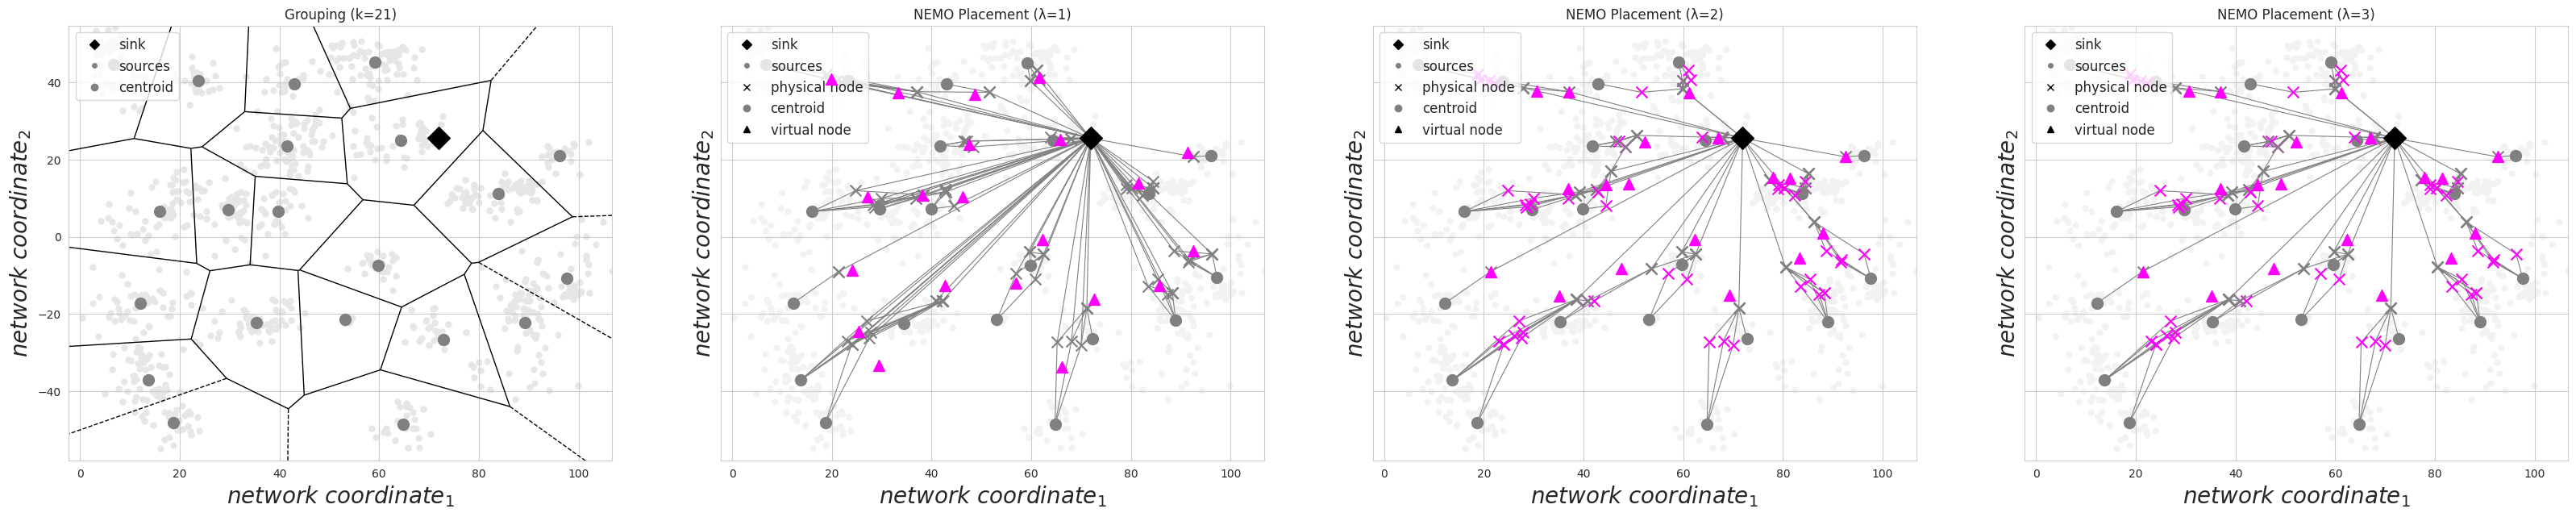

In [89]:
levels = [1, 2, 3]
fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1
weight_col_plot = "weight_2"
slot_col_plot = "capacity_10"
single_color = "grey"

util.plot_topology(axs[0], prim_df, None, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, plot_centroid=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size,
                   point_color=single_color, centroid_color=single_color)

for i, level in enumerate(levels):
    df_dict_i, opt_dict_i, limits_dict_i = evaluate_nemo(prim_df, [slot_col_plot], weight_col_plot,
                                                         merge_factor=param_dict[weight_col_plot]["merge_factor"],
                                                         step_size=param_dict[weight_col_plot]["step_size"],
                                                         max_levels=level, with_eval=False)
    
    util.plot_with_single_color(axs[i + 1], prim_df, df_dict_i[slot_col_plot], single_color,
                                opt_dict=opt_dict_i[slot_col_plot], leg_size=leg_size, symbol_size=symbol_size,
                                scale_fac=scale_fac, axis_label_size=axis_label_size, lval=lval, plot_centroids=True,
                                plot_lines=True, highlight_color="magenta")
    axs[i+1].set_title(f"NEMO Placement (λ={str(level)})")

plt.show()

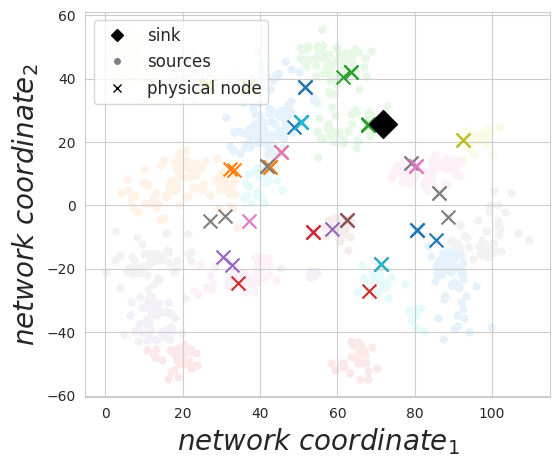

In [90]:
ax = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot(ax, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


ax.set_xlabel('$network$ $coordinate_1$')
ax.set_ylabel('$network$ $coordinate_2$')

plt.savefig("plots/sim_1000/nemo_placement.svg", bbox_inches="tight")

Distribution of workload:  4.6953 %


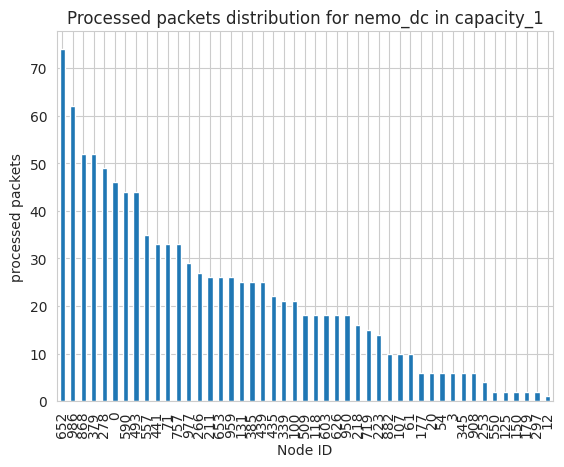

In [91]:
eval_col = list(eval_matrix[eval_name])[-1]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 3: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [92]:
# the adjacency matrix for the plane
df = prim_df.copy()
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:38755.0, valueBest:38747.0
i:10, t(i):3.49, valueNow:22223.0, valueBest:22218.0
i:20, t(i):1.22, valueNow:18721.0, valueBest:18721.0
i:30, t(i):0.42, valueNow:16770.0, valueBest:16770.0
i:40, t(i):0.15, valueNow:15628.0, valueBest:15628.0
i:50, t(i):0.05, valueNow:14754.0, valueBest:14754.0
i:60, t(i):0.02, valueNow:14208.0, valueBest:14208.0


In [93]:
print(route)

[940 743 821 ...  20 765 297]


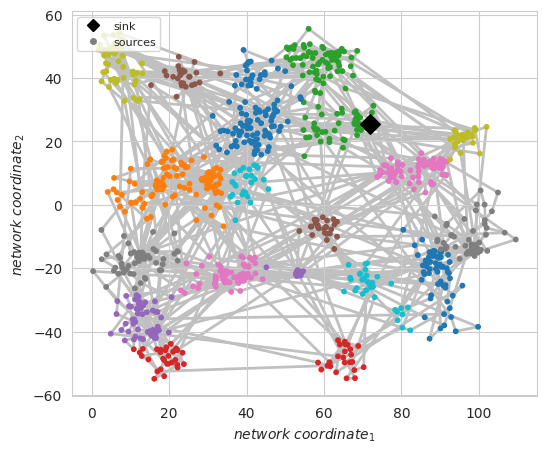

In [94]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/sim_1000/chain_50n.svg", bbox_inches="tight")
plt.show()

In [95]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  558  in route.


In [96]:
print(df_stats["received_packets"])

0       2.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
996     1.0
997     1.0
998     1.0
999     1.0
1000    1.0
Name: received_packets, Length: 1001, dtype: float64


count    1001.000000
mean     3673.785094
std      2094.478654
min         0.000000
25%      1970.349210
50%      3634.411986
75%      5352.862427
max      7781.935286
Name: latency_distribution, dtype: float64


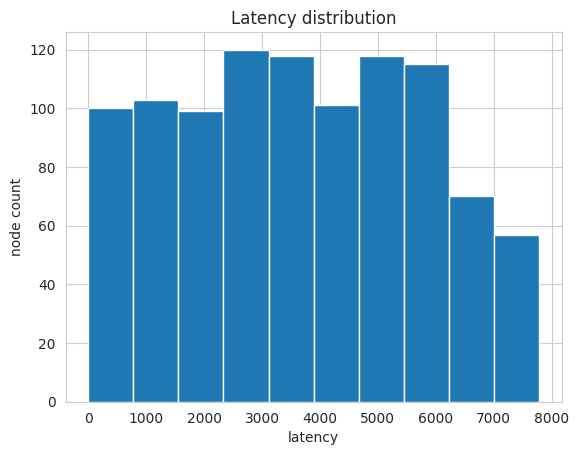

In [97]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count    1001.000000
mean        0.999001
std         0.054763
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: received_packets, dtype: float64


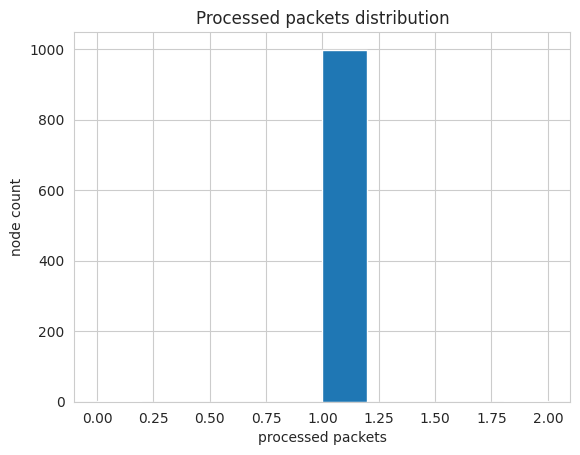

In [98]:
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [99]:
np.where(received_packets_hist > 1)

(array([0]),)

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [100]:
df = prim_df.copy()
mst = prim_mst(coords)

In [101]:
print(mst)

[-1, 221, 154, 43, 311, 231, 811, 212, 547, 544, 208, 612, 807, 205, 317, 541, 350, 877, 667, 633, 297, 226, 699, 773, 228, 915, 94, 594, 723, 947, 663, 570, 967, 980, 180, 870, 940, 198, 217, 573, 459, 631, 697, 263, 170, 272, 762, 797, 977, 719, 609, 251, 317, 591, 626, 79, 358, 834, 514, 739, 274, 131, 741, 745, 685, 434, 546, 139, 931, 736, 375, 12, 0, 869, 796, 771, 354, 424, 671, 279, 230, 205, 979, 390, 959, 353, 207, 801, 641, 489, 257, 758, 799, 625, 209, 371, 395, 99, 450, 506, 385, 623, 674, 427, 802, 258, 364, 388, 871, 578, 355, 889, 346, 785, 598, 374, 418, 836, 175, 518, 622, 324, 425, 519, 381, 54, 694, 610, 166, 847, 209, 71, 589, 484, 352, 269, 513, 116, 238, 486, 448, 263, 641, 245, 128, 939, 412, 716, 362, 886, 20, 878, 332, 337, 833, 736, 373, 972, 553, 594, 756, 470, 759, 771, 463, 958, 189, 302, 329, 881, 703, 133, 898, 112, 946, 810, 730, 941, 826, 35, 227, 818, 894, 760, 431, 18, 206, 558, 680, 253, 515, 824, 228, 682, 400, 351, 212, 8, 432, 504, 545, 249, 104,

In [102]:
routes = createRoutes(mst)
print(routes[3])

[43, 263, 850, 452, 973, 462, 720, 656, 791, 383, 182, 894, 999, 528, 896, 320, 757, 774, 698, 108, 871, 46, 762, 283, 704, 775, 846, 448, 874, 634, 292, 493, 107, 388, 126, 694, 865, 717, 754, 406, 886, 780, 344, 123, 519, 466, 144, 128, 166, 189, 253, 763, 555, 867, 72, 0]


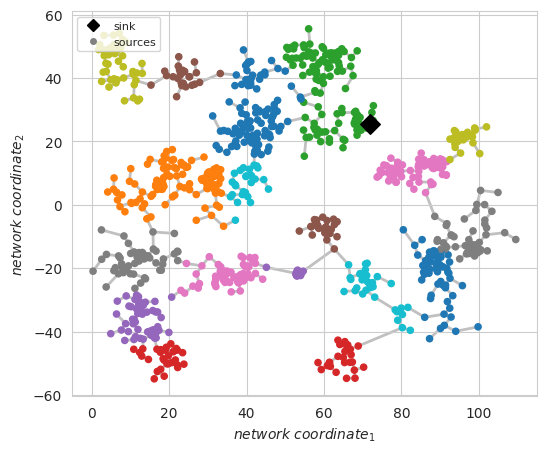

In [103]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/sim_1000/mst.svg", bbox_inches="tight")
plt.show()

In [104]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

count    1001.000000
mean      157.629558
std        90.233635
min         0.000000
25%        84.388262
50%       143.721163
75%       224.671331
max       336.346736
Name: latency_distribution, dtype: float64


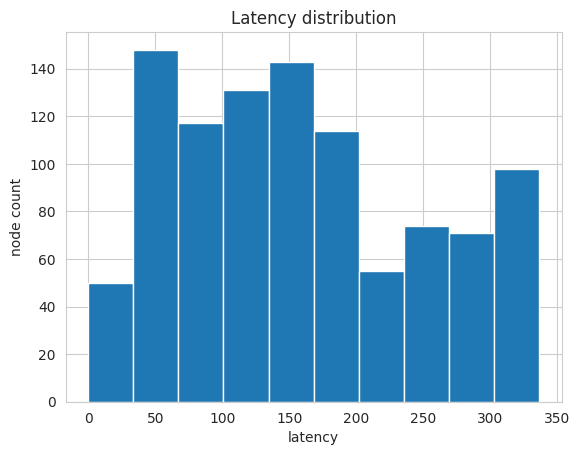

In [105]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

Distribution of workload:  76.6234 %


Text(0.5, 1.0, 'Processed packets distribution')

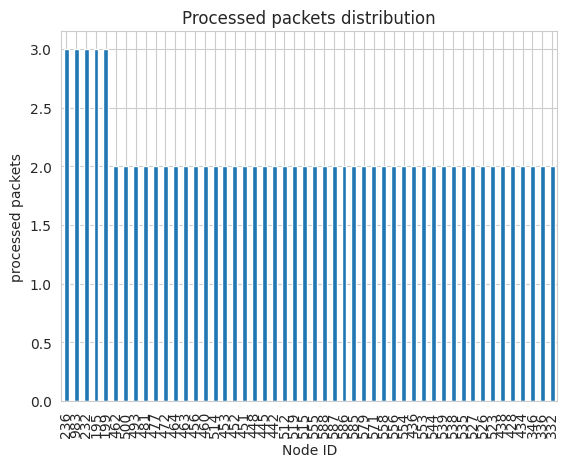

In [106]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")

df_packets = df_packets.head(int(round(device_number * 0.05)))
df_packets.plot.bar()

plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution")

In [107]:
eval_matrix["mst"] = df_stats.copy()

## Evaluation

In [108]:
eval_matrix.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_1', 'nemo_dc_weight_2', 'nemo_dc_weight', 'nemo_dc', 'chain', 'mst'])

In [109]:
eval_matrix["nemo_dc"].keys()

dict_keys(['capacity_100', 'capacity_90', 'capacity_80', 'capacity_70', 'capacity_60', 'capacity_50', 'capacity_40', 'capacity_30', 'capacity_20', 'capacity_10', 'capacity_5', 'capacity_1'])

In [110]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

#### Latency

In [111]:
heterogen_appr

['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

In [112]:
eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8],
    "nemo_dc_weight_2": colors[9],
    "nemo_dc_weight": colors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
    "capacity_100": "m=" + first_med_label,
    "capacity_1": "m=" + last_med_label
}


In [113]:
eval_matrix["dt"]["latency_distribution"].mean()

48.27046588948662

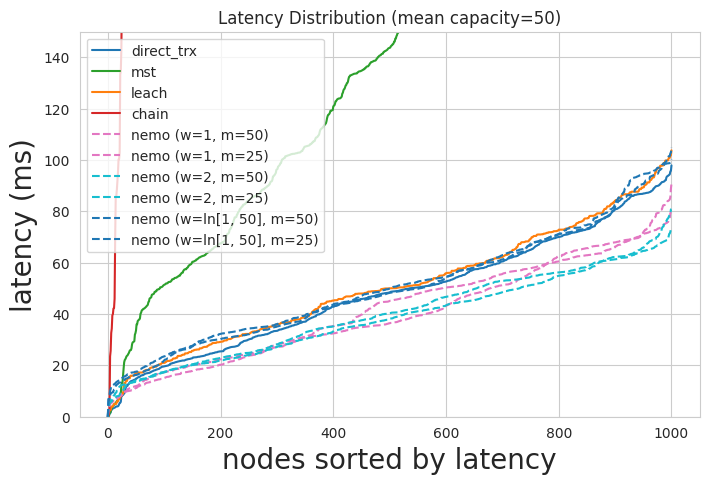

Means:  {'dt': 48.27, 'mst': 157.63, 'leach': 50.84, 'chain': 3673.79, 'nemo (w=1, m=50)': 40.19, 'nemo (w=1, m=25)': 41.86, 'nemo (w=2, m=50)': 39.93, 'nemo (w=2, m=25)': 38.68, 'nemo (w=ln[1, 50], m=50)': 50.54, 'nemo (w=ln[1, 50], m=25)': 50.88}
Quantiles:  {'dt': 80.81, 'mst': 299.1, 'leach': 83.95, 'chain': 6551.59, 'nemo (w=1, m=50)': 67.93, 'nemo (w=1, m=25)': 66.29, 'nemo (w=2, m=50)': 61.32, 'nemo (w=2, m=25)': 62.24, 'nemo (w=ln[1, 50], m=50)': 82.86, 'nemo (w=ln[1, 50], m=25)': 81.62}


In [114]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for approach in heterogen_appr:
    cl = approach
    emat = eval_matrix[approach]

    for capacity, df in emat.items():
        if capacity not in ["capacity_100", "capacity_1"]:
            continue
        l = renaming_dict[approach] + " " + renaming_dict[capacity] + ")"

        sv = df["latency_distribution"].sort_values()
        quant_dict[l] = round(sv.quantile(0.9), 2)
        mean_dict[l] = round(sv.mean(), 2)
        sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl], linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 150])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

#### Heterogeneity

In [115]:
aggregation_fams

['dt', 'leach', 'mst', 'chain']

In [116]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.pop("nemo_dc_weight_2")
eval_matrix_load.pop("nemo_dc_weight")
eval_matrix_load.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_1', 'nemo_dc', 'chain', 'mst'])

In [117]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

In [118]:
load_dict

{'dt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'leach': [1.05, 1.05, 1.1, 1.1, 1.05, 1.15, 1.25, 1.4, 1.85, 4.1, 6.3, 20.0],
 'chain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 72],
 'mst': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 58]}

In [119]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix_load.items():
    if k in heterogen_appr:
        slot_list = []
        nn_list = []
        for colname in slot_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            slot_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

#for k, mat in eval_matrix.items():
#    if k in heterogen_appr:
#        slot_list = []
#        nn_list = []
#        for colname in slot_columns:
#            df = mat["base"]
#            df["av_capacity"] = prim_df[colname] - df["received_packets"]
#            tmp_df_sl = df[df["av_capacity"] < 0]
#            tmp_df_nn = df[df["av_capacity"] >= 0]
#            slot_list.append(tmp_df_sl["av_capacity"].count())
#            nn_list.append(tmp_df_nn["av_capacity"].count())
#        load_dict[k + "_base"] = slot_list
#        nn_dict[k + "_base"] = nn_list

In [120]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

In [121]:
agg_arr1 = []
for fam in load_dict.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])

#agg_arr2 = []
#for fam in eval_matrix_load.keys():
#    agg_arr2.append(load_dict[fam + "_base"])
#mr = np.mean(np.array(agg_arr2), axis=0)
#load_dict["NEMO_base"] = mr
#print(mr)

Fam:  dt
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fam:  leach
[1.05, 1.05, 1.1, 1.1, 1.05, 1.15, 1.25, 1.4, 1.85, 4.1, 6.3, 20.0]
Fam:  chain
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 72]
Fam:  mst
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 58]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


dt [50. 51. 50. 50. 49. 49. 47. 45. 42. 36. 30. 23.]
dt [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leach [50. 51. 50. 50. 49. 49. 47. 45. 42. 36. 30. 23.]
leach [1.05, 1.05, 1.1, 1.1, 1.05, 1.15, 1.25, 1.4, 1.85, 4.1, 6.3, 20.0]
chain [50. 51. 50. 50. 49. 49. 47. 45. 42. 36. 30. 23.]
chain [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 72]
mst [50. 51. 50. 50. 49. 49. 47. 45. 42. 36. 30. 23.]
mst [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 58]
nemo_dc [50. 51. 50. 50. 49. 49. 47. 45. 42. 36. 30. 23.]
nemo_dc [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


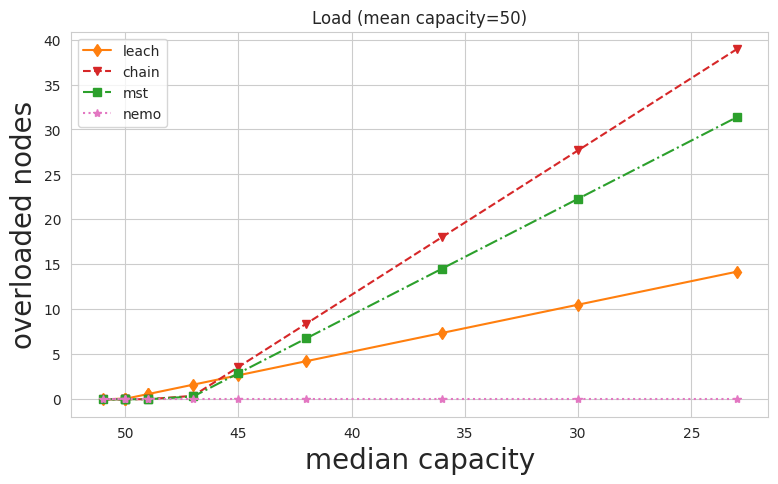

In [122]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    print(fam, medians)
    print(fam, vals)
    m, b = np.polyfit(medians, vals, 1)
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "nemo_dc":
        fam = "nemo"
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_load_abs.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()


In [123]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

leach - d #ff7f0e : [1.05, 1.05, 1.1, 1.1, 1.05, 1.15, 1.25, 1.4, 1.8500000000000003, 4.1, 6.3, 20.0]
chain -- v #d62728 : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.207207207207207]
mst -. s #2ca02c : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.600000000000001]
nemo : * #e377c2 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


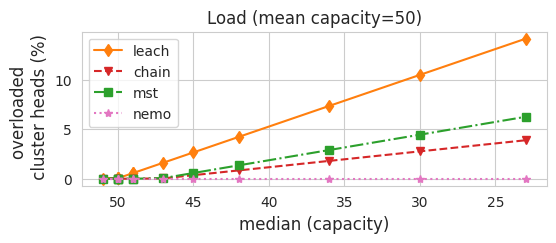

In [124]:
fig, ax = plt.subplots(figsize=(6, 2))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    if fam == "dt":
        fam = "direct_trx"
        vals = [100 for x in vals]
        continue
    if fam == "leach":
        vals = [x / num_leach_clusters * 100 for x in vals]
    if fam == "mst":
        agg_points = (device_number - 1) / 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "chain":
        agg_points = device_number - 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "nemo_dc":
        fam = "nemo"
    m, b = np.polyfit(medians, vals, 1)
    print(fam, styles[i], markers[i], eval_colors[evcol], ":", vals)
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median (capacity)")
ax.set_ylabel("overloaded \n cluster heads (%)")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(12)
ax.xaxis.label.set_size(12)

plt.savefig("plots/sim_1000/eval_load_perc.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [125]:
quant_dict

{'dt': 80.81,
 'mst': 299.1,
 'leach': 83.95,
 'chain': 6551.59,
 'nemo (w=1, m=50)': 67.93,
 'nemo (w=1, m=25)': 66.29,
 'nemo (w=2, m=50)': 61.32,
 'nemo (w=2, m=25)': 62.24,
 'nemo (w=ln[1, 50], m=50)': 82.86,
 'nemo (w=ln[1, 50], m=25)': 81.62}

In [126]:
mean_dict

{'dt': 48.27,
 'mst': 157.63,
 'leach': 50.84,
 'chain': 3673.79,
 'nemo (w=1, m=50)': 40.19,
 'nemo (w=1, m=25)': 41.86,
 'nemo (w=2, m=50)': 39.93,
 'nemo (w=2, m=25)': 38.68,
 'nemo (w=ln[1, 50], m=50)': 50.54,
 'nemo (w=ln[1, 50], m=25)': 50.88}